In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

C:\Users\spark\AppData\Local\Temp\ipykernel_35116\1656186547.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df = pd.read_csv('dataset.csv')
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)
df = df[df['STATION'].isin({'USW00023047'})]
df['DATE'] = df['DATE'].apply(str_to_datetime)
df.index = df.pop('DATE')
df = df[['th_power']]
df

,th_power
DATE,
2010-01-01,199960.624705
2010-01-02,199960.624705
2010-01-03,89858.344550
2010-01-04,30093.377778
2010-01-05,437159.998808
...,...
2023-05-03,718866.756403
2023-05-04,356677.306291
2023-05-05,605588.541531


In [3]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['th_power'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date =datetime. datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2022-01-11', 
                                '2023-05-03', 
                                n=10)
windowed_df

,Target Date,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2022-01-11,1.549172e+06,1.232625e+05,4.590141e+05,5.792624e+05,3.382322e+05,5.537104e+05,1.357754e+06,1.141534e+06,2.708077e+05,7.569857e+04,5.537104e+05
1,2022-01-12,1.232625e+05,4.590141e+05,5.792624e+05,3.382322e+05,5.537104e+05,1.357754e+06,1.141534e+06,2.708077e+05,7.569857e+04,5.537104e+05,5.200136e+04
2,2022-01-13,4.590141e+05,5.792624e+05,3.382322e+05,5.537104e+05,1.357754e+06,1.141534e+06,2.708077e+05,7.569857e+04,5.537104e+05,5.200136e+04,5.200136e+04
3,2022-01-14,5.792624e+05,3.382322e+05,5.537104e+05,1.357754e+06,1.141534e+06,2.708077e+05,7.569857e+04,5.537104e+05,5.200136e+04,5.200136e+04,2.426175e+06
4,2022-01-15,3.382322e+05,5.537104e+05,1.357754e+06,1.141534e+06,2.708077e+05,7.569857e+04,5.537104e+05,5.200136e+04,5.200136e+04,2.426175e+06,1.651284e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
473,2023-04-29,8.454573e+05,6.327005e+05,1.999606e+05,1.225029e+06,1.426917e+05,7.492375e+05,1.023543e+06,3.757811e+05,2.867336e+05,1.499735e+06,3.032719e+05
474,2023-04-30,6.327005e+05,1.999606e+05,1.225029e+06,1.426917e+05,7.492375e+05,1.023543e+06,3.757811e+05,2.867336e+05,1.499735e+06,3.032719e+05,1.531286e+05
475,2023-05-01,1.999606e+05,1.225029e+06,1.426917e+05,7.492375e+05,1.023543e+06,3.757811e+05,2.867336e+05,1.499735e+06,3.032719e+05,1.531286e+05,2.867336e+05
476,2023-05-02,1.225029e+06,1.426917e+05,7.492375e+05,1.023543e+06,3.757811e+05,2.867336e+05,1.499735e+06,3.032719e+05,1.531286e+05,2.867336e+05,4.160109e+05


In [4]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((478,), (478, 10, 1), (478,))

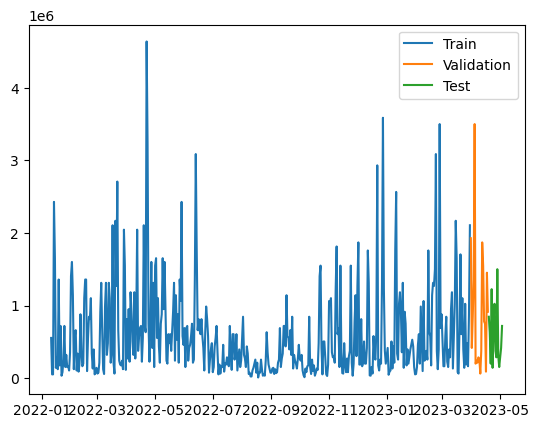

In [5]:
q_80 = int(len(dates) * .93)
q_90 = int(len(dates) * .97)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((10, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
14/14 [==============================] - 2s 40ms/step - loss: 734611963904.0000 - mean_absolute_error: 584130.1875 - val_loss: 1532645081088.0000 - val_mean_absolute_error: 898952.8125
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 734611308544.0000 - mean_absolute_error: 584129.5625 - val_loss: 1532643770368.0000 - val_mean_absolute_error: 898952.1875
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 734610456576.0000 - mean_absolute_error: 584128.8125 - val_loss: 1532642328576.0000 - val_mean_absolute_error: 898951.3750
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 734609276928.0000 - mean_absolute_error: 584127.8750 - val_loss: 1532640231424.0000 - val_mean_absolute_error: 898950.1875
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 734607638528.0000 - mean_absolute_error: 584126.4375 - val_loss: 1532637085696.0000 - val_mean_absolute_error: 898948.5000
Epoch 6/100
14/14 [

14/14 [==============================] - 0s 2ms/step


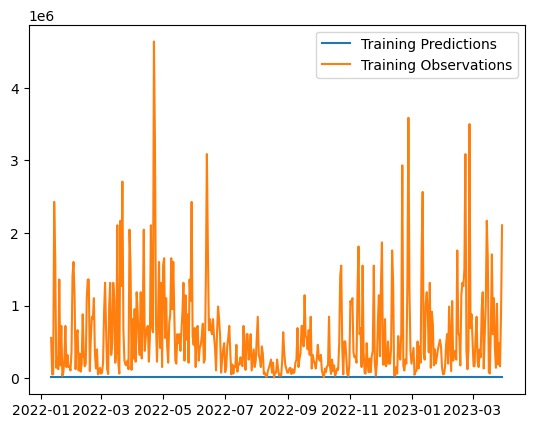

In [7]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 21ms/step


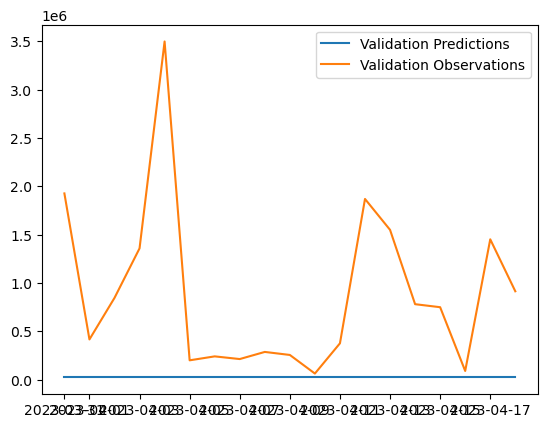

In [8]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 26ms/step


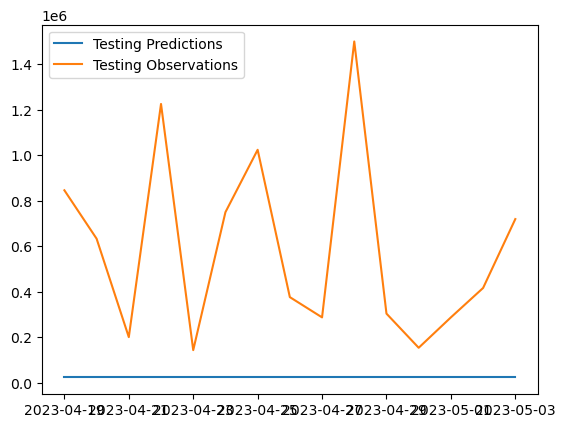

In [9]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

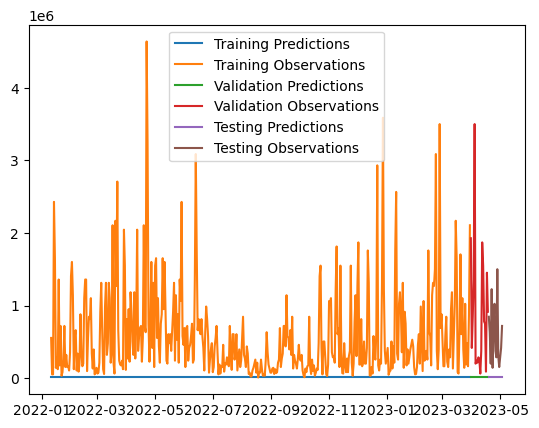

In [10]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [11]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 20ms/step


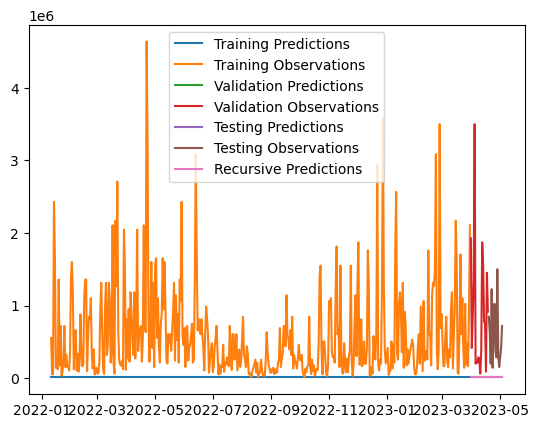

In [12]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])